In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions, TransitionPotential, EELSDetector
from abtem import SMatrix, Potential, GridScan

from ase import units
from ase.io import read


ImportError: cannot import name 'Measurement' from 'abtem.measure' (/Users/Zezhong/OneDrive - Universiteit Antwerpen/code/abTEM/abtem/measure/__init__.py)

In [2]:
Z = 8 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=1)

print('bound electron configuration:', O_transitions.bound_configuration)
print('ionic electron configuration:', O_transitions.excited_configuration)



bound electron configuration: 1s2 2s2 2p4
ionic electron configuration: 1s1 2s2 2p4


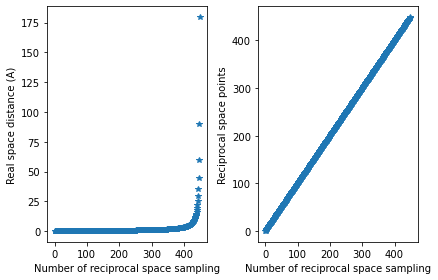

In [27]:
import numpy as np
import matplotlib.pyplot as plt
maxnodes = 2
gpts = 150
N =(maxnodes+1)*gpts
beta = 0.4
g = np.arange(0,N)
r = np.dot(beta, g) / (N-g)
ax1 = plt.subplot(121)
ax1.plot(g,r,'*')
plt.xlabel('Number of reciprocal space sampling')
plt.ylabel('Real space distance (A)')
ax2 = plt.subplot(122)
G = r*N/(beta+r)
ax2.plot(g,G,'*')
plt.xlabel('Number of reciprocal space sampling')
plt.ylabel('Reciprocal space points')
plt.tight_layout()

/Users/Zezhong/anaconda3/envs/em/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


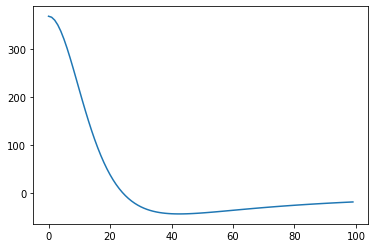

In [3]:
rmax=20
r = np.linspace(0, rmax, 10000)

from scipy.fft import fft, ifft
# u=O_transitions.get_continuum_waves()[1](r)
u=O_transitions.get_bound_wave()(r)

v = fft(u)

fig, ax = plt.subplots(1,1,figsize=(6, 4))
ax.plot(v[:100])
plt.show()


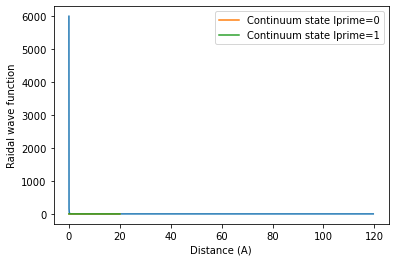

In [3]:
rmax=20
r = np.linspace(0, rmax, 10000)

fig, ax = plt.subplots(1,1,figsize=(6, 4))
ax.plot(r,O_transitions.get_bound_wave()(r),label='Ground state l=0')

for i in O_transitions.lprimes:
    x = O_transitions.get_continuum_waves()[i](r)
    # y = O_transitions.get_continuum_waves()[1](r)
    ax.plot(r,x,label='Continuum state lprime='+str(i))
plt.xlabel('Distance (A)')
plt.ylabel('Raidal wave function')
plt.legend()
plt.show()

In [12]:
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')



(l, ml) = (0, 0) -> (1, -1)
(l, ml) = (0, 0) -> (1, 0)
(l, ml) = (0, 0) -> (1, 1)


In [8]:
atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
                                                                       gpts = 256,
                                                                       energy = 100e3)


Transitions: 100%|██████████| 3/3 [00:00<00:00, 4946.11it/s] 


In [73]:

from typing import Callable, Optional, Tuple

import numpy as np

# from quadpy.c1._gauss_kronrod import _gauss_kronrod_integrate

import math
from collections import namedtuple

import numpy as np
import orthopy

from quadpy.helpers import article
from quadpy.tools import scheme_from_rc
from quadpy.c1._gauss_legendre import gauss_legendre
from quadpy.c1._helpers import C1Scheme, _find_shapes
from quadpy.c1._gauss_kronrod import gauss_kronrod
def integrate_adaptive(
    f: Callable,
    intervals,
    eps_abs: Optional[float] = 1.0e-10,
    eps_rel: Optional[float] = 1.0e-10,
    criteria_connection: Callable = np.any,
    # Use 21-point Gauss-Kronrod like QUADPACK
    # <https://en.wikipedia.org/wiki/QUADPACK#General-purpose_routines>
    kronrod_degree: int = 10,
    minimum_interval_length: float = 0.0,
    max_num_subintervals=np.inf,
    dot: Callable = np.dot,
    domain_shape: Optional[Tuple] = None,
    range_shape: Optional[Tuple] = None,
):
    intervals = np.asarray(intervals)
    assert intervals.shape[0] == 2
    assert np.all(intervals > -np.inf)
    assert np.all(intervals < np.inf)

    assert (
        eps_abs is not None or eps_rel is not None
    ), "One of eps_abs, eps_rel must be specified."

    
    # Use Gauss-Kronrod scheme for error estimation and adaptivity.
    # The method also returns guesses for the domain_shape and range_shape (if any of
    # them is None).
    out = _gauss_kronrod_integrate(
        kronrod_degree,
        f,
        intervals,
        dot=dot,
        domain_shape=domain_shape,
        range_shape=range_shape,
    )
    value_estimates = out.val_gauss_legendre
    interval_lengths = out.interval_lengths
    error_estimates = out.error_estimate
    domain_shape = out.domain_shape
    range_shape = out.range_shape
    total_sampling = []
    total_weights = []
    sampling = out.sampling
    weights = out.weights
    total_sampling.append(sampling)
    total_weights.append(weights)
    # Flatten the list of intervals so we can do good-bad bookkeeping via a list.
    intervals = intervals.reshape((2,) + domain_shape + (-1,))
    num_subintervals = 1
    orig_shape = value_estimates.shape
    value_estimates = value_estimates.reshape(range_shape + (-1,))
    error_estimates = error_estimates.reshape(range_shape + (-1,))

    # Mark intervals with acceptable approximations. For this, take all() across every
    # dimension except the last one (which is the interval index).
    criteria = []
    if eps_abs is not None:
        is_okay = error_estimates < eps_abs
        criteria.append(_numpy_all_except_last(is_okay))
    if eps_rel is not None:
        is_okay = error_estimates < eps_rel * np.abs(value_estimates)
        criteria.append(_numpy_all_except_last(is_okay))
    is_good = criteria_connection(criteria, axis=0)

    good_values_sum = np.sum(value_estimates[..., is_good], axis=-1)
    good_errors_sum = np.sum(error_estimates[..., is_good], axis=-1)

    while np.any(~is_good):
        # split the bad intervals in half
        bad_intervals = intervals[..., ~is_good]
        midpoints = 0.5 * (bad_intervals[0] + bad_intervals[1])
        intervals = np.array(
            [
                np.concatenate([bad_intervals[0], midpoints], axis=-1),
                np.concatenate([midpoints, bad_intervals[1]], axis=-1),
            ]
        )
        # idx = np.concatenate([idx[~is_good], idx[~is_good]])
        num_subintervals += np.sum(is_good)

        if num_subintervals > max_num_subintervals:
            raise IntegrationError(
                f"Tolerances (abs: {eps_abs}, rel: {eps_rel}) could not be reached "
                f"with the given max_num_subintervals (= {max_num_subintervals})."
            )

        # compute values and error estimates for the new intervals
        out = _gauss_kronrod_integrate(
            kronrod_degree,
            f,
            intervals,
            dot=dot,
            domain_shape=domain_shape,
            range_shape=range_shape,
        )
        value_estimates = out.val_gauss_legendre
        interval_lengths = out.interval_lengths
        error_estimates = out.error_estimate
        sampling = out.sampling
        weights = out.weights
        total_sampling.append(sampling)
        total_weights.append(weights)
        # mark good intervals, gather values and error estimates
        if np.any(interval_lengths < minimum_interval_length):
            raise IntegrationError(
                f"Tolerances (abs: {eps_abs}, rel: {eps_rel}) could not be reached "
                f"with the given minimum_interval_length (= {minimum_interval_length})."
            )

        # tentative total value (as if all intervals were good)
        ttv = good_values_sum + np.sum(value_estimates, axis=-1)

        # distribute the remaining allowances according to the interval lengths
        tau = interval_lengths / np.sum(interval_lengths)

        criteria = []
        if eps_abs is not None:
            allowance_abs = eps_abs - good_errors_sum
            is_okay = error_estimates < np.multiply.outer(allowance_abs, tau)
            criteria.append(_numpy_all_except_last(is_okay))
        if eps_rel is not None:
            # allowance_rel = eps_rel - good_errors_sum / np.abs(ttv)
            # is_okay = error_estimates < tau * allowance_rel * np.abs(ttv)
            allowance_rel_ttv = eps_rel * np.abs(ttv) - good_errors_sum
            is_okay = error_estimates < np.multiply.outer(allowance_rel_ttv, tau)
            criteria.append(_numpy_all_except_last(is_okay))
        is_good = criteria_connection(criteria, axis=0)

        good_values_sum += np.sum(value_estimates[..., is_good], axis=-1)
        good_errors_sum += np.sum(error_estimates[..., is_good], axis=-1)

    good_values_sum = good_values_sum.reshape(orig_shape)
    good_errors_sum = good_errors_sum.reshape(orig_shape)
    # total_sampling_sorted,total_weights_sorted = [sorted(zip(total_sampling, total_weights))]
    return good_values_sum, good_errors_sum, total_sampling, total_weights

def _gauss_kronrod_integrate(
    k,
    f,
    intervals,
    dot=np.dot,
    domain_shape=None,
    range_shape=None,
):
    # Compute the integral estimations according to Gauss and Gauss-Kronrod, sharing the
    # function evaluations
    gk = gauss_kronrod(k)
    gl = gauss_legendre(k)
    # scale points
    x0 = 0.5 * (1.0 - gk.points)
    x1 = 0.5 * (1.0 + gk.points)

    sp = np.multiply.outer(intervals[0], x0) + np.multiply.outer(intervals[1], x1)
    if domain_shape is not None and range_shape is not None:
        # Make it easy on the f by flattening out interval_set
        interval_set_shape = intervals.shape[1 + len(domain_shape) :]
        sp = sp.reshape(*domain_shape, -1)
        fx_gk = [] 
        for p in sp:
            fx_gk.append(f(p))
        fx_gk = np.array(fx_gk)
        fx_gk = fx_gk.reshape(*range_shape, *interval_set_shape, *x0.shape)
    else:
        fx_gk = [] 
        for p in sp:
            fx_gk.append(f(p))
        # try and guess shapes of domain, range, intervals
        fx_gk = np.array(fx_gk)
        domain_shape, range_shape, interval_set_shape = _find_shapes(
            fx_gk, intervals, gk.points, domain_shape, range_shape
        )

    fx_gl = fx_gk[..., 1::2]

    diff = intervals[1] - intervals[0]
    interval_lengths = np.sqrt(np.sum(diff ** 2, axis=tuple(range(len(domain_shape)))))
    assert interval_lengths.shape == interval_set_shape

    # integrate
    # average value of gk over the interval
    average_gk = 0.5 * dot(fx_gk, gk.weights)
    val_gauss_kronrod = average_gk * interval_lengths
    val_gauss_legendr = 0.5 * interval_lengths * dot(fx_gl, gl.weights)
    weights = [None]*(sp.size)
    weights[::2] = gk.weights
    weights[1::2] = gl.weights

    assert val_gauss_kronrod.shape == range_shape + interval_set_shape
    assert val_gauss_legendr.shape == range_shape + interval_set_shape

    # Get an error estimate. According to
    #
    #   Pedro Gonnet,
    #   A Review of Error Estimation in Adaptive Quadrature,
    #   ACM Computing Surveys (CSUR) Surveys,
    #   Volume 44, Issue 4, August 2012
    #   <https://doi.org/10.1145/2333112.2333117>,
    #   <https://arxiv.org/pdf/1003.4629.pdf>
    #
    # the classical QUADPACK still compares favorably with other approaches.
    fx_avg_abs = np.abs(fx_gk - average_gk[..., None])
    I_tilde = 0.5 * interval_lengths * dot(fx_avg_abs, gk.weights)

    # The exponent 1.5 is chosen such that (200*x)**1.5 is approximately x at 1.0e-6,
    # the machine precision on IEEE 754 32-bit floating point arithmentic. This could be
    # adapted to
    #
    #   eps = np.finfo(float).eps
    #   exponent = np.log(eps) / np.log(200*eps)
    #
    # The following expression is
    #
    # error_estimate = I_tilde * np.minimum(
    #     np.ones(I_tilde.shape),
    #     (200 * abs(val_gauss_kronrod - val_gauss_legendr) / I_tilde) ** 1.5,
    # )
    #
    # with handling NaNs (if I_tilde is 0).
    error_estimate = np.empty(I_tilde.shape)
    idx = np.abs(I_tilde) > 1.0e-15
    vals = (
        200 * np.abs(val_gauss_kronrod[idx] - val_gauss_legendr[idx]) / I_tilde[idx]
    ) ** 1.5
    error_estimate[idx] = np.minimum(np.ones(np.sum(idx)), vals)
    error_estimate[~idx] = 1.0
    error_estimate *= I_tilde

    assert error_estimate.shape == rtransitionsange_shape + interval_set_shape
    gk_return = namedtuple(
        "gauss_kronrod_return_values",
        [
            "val_gauss_kronrod",
            "val_gauss_legendre",
            "interval_lengths",
            "error_estimate",
            "domain_shape",
            "range_shape",
            "sampling",
            "weight"
        ],
    )

    return gk_return(
        val_gauss_kronrod,
        val_gauss_legendr,
        interval_lengths,
        error_estimate,
        domain_shape,
        range_shape,
        sp,
        weights

    )

def _numpy_all_except_last(a):
    return np.all(a, axis=tuple(range(len(a.shape) - 1)))

In [85]:
from typing import Union

import numpy as np
import orthopy

from quadpy.tools import scheme_from_rc
from quadpy.e1r._helpers import E1rScheme


def gauss_laguerre(n: int, alpha: Union[int, float] = 0, mode: str = "numpy"):
    """
    Gauss-Laguerre quadrature for integrals of the form

        int_0^{+inf} exp(-alpha * x) f(x) dx.
    """
    symbolic = mode != "numpy"
    rc = orthopy.e1r.RecurrenceCoefficients("monic", alpha, symbolic)

    _, a, b = np.array([rc[k] for k in range(n)]).T
    points, weights = scheme_from_rc(a, b, rc.int_1, mode=mode)

    if alpha == 0:
        name = f"Gauss-Laguerre ({n})"
    else:
        name = f"Generalized Gauss-Laguerre (n={n}, alpha={alpha})"

    return E1rScheme(name, weights, points, 2 * n - 1)

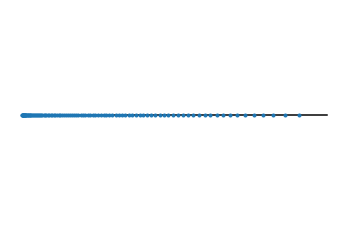

array([1.43861470e-02, 7.58036120e-02, 1.86314102e-01, 3.45969181e-01,
       5.54810938e-01, 8.12891284e-01, 1.12027384e+00, 1.47703433e+00,
       1.88326083e+00, 2.33905385e+00, 2.84452654e+00, 3.39980483e+00,
       4.00502758e+00, 4.66034684e+00, 5.36592799e+00, 6.12195003e+00,
       6.92860583e+00, 7.78610238e+00, 8.69466111e+00, 9.65451824e+00,
       1.06659251e+01, 1.17291485e+01, 1.28444712e+01, 1.40121922e+01,
       1.52326276e+01, 1.65061105e+01, 1.78329919e+01, 1.92136416e+01,
       2.06484480e+01, 2.21378194e+01, 2.36821848e+01, 2.52819939e+01,
       2.69377187e+01, 2.86498542e+01, 3.04189188e+01, 3.22454560e+01,
       3.41300351e+01, 3.60732524e+01, 3.80757324e+01, 4.01381291e+01,
       4.22611275e+01, 4.44454451e+01, 4.66918335e+01, 4.90010802e+01,
       5.13740103e+01, 5.38114889e+01, 5.63144230e+01, 5.88837640e+01,
       6.15205103e+01, 6.42257101e+01, 6.70004645e+01, 6.98459306e+01,
       7.27633254e+01, 7.57539295e+01, 7.88190913e+01, 8.19602322e+01,
      

In [6]:
scheme = quadpy.e1r.gauss_laguerre(35, alpha=0)
scheme.show()
scheme.points

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from abtem.ionization import SubshellTransitions, TransitionPotential, EELSDetector
from abtem import SMatrix, Potential, GridScan

from ase import units
from ase.io import read

from typing import Union

import numpy as np
import cupy as cp
import orthopy
from numba import jit,vectorize,guvectorize,float64

# from quadpy.e1r.tools import scheme_from_rc


# def gauss_laguerre(n: int, alpha: Union[int, float] = 0, mode: str = "numpy"):
#     """
#     Gauss-Laguerre quadrature for integrals of the form

#         int_0^{+inf} exp(-alpha * x) f(x) dx.
#     """
#     symbolic = mode != "numpy"
#     rc = orthopy.e1r.RecurrenceCoefficients("monic", alpha, symbolic)

#     _, a, b = np.array([rc[k] for k in range(n)]).T
#     points, weights = scheme_from_rc(a, b, rc.int_1, mode=mode)
#     return points, weights

Z = 79 # atomic number
n = 1 # principal quantum number
l = 0 # azimuthal quantum number
xc = 'PBE' # exchange-correlation functional

# @vectorize([float64(float64)])
def differentital_edx_potential(E):
    transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=E)
    atomic_transition_potentials = transitions.get_transition_potentials(extent = 5,
                                                                    gpts = 256,
                                                                    energy = 3e5)
    intensity = None
    for t in atomic_transition_potentials:
        pot = t.measure().intensity().array
        if intensity is None:
            intensity = pot
        else:
            intensity += pot
    # intensity_list.append(intensity)
    # total_list.append(intensity.sum())
    # return np.dot(intensity.sum(),np.exp(E))          
    return intensity
 

@jit(nopython=False)
def vector_edx_potential(x_list):
    y_list = []
    for x in x_list:
        y_list.append(differentital_edx_potential(x))
    return y_list

# vector1000_edx_potential = vectorize(differentital_edx_potential)

# from numpy import pi, sin


In [ ]:

import quadpy

scheme = quadpy.e1r.gauss_laguerre(10, alpha=1)
scheme.show()
val = scheme.integrate(differentital_edx_potential)

# val, error_estimate = quadpy.c1.integrate_adaptive(differentital_edx_potential,intervals=[0,300e3],eps_rel=1e-1)
# val, error_estimate, total_sampling, total_weights = integrate_adaptive(differentital_edx_potential, [1, 2], eps_rel=1.0E-2,kronrod_degree=10)

In [ ]:
import tanh_sinh
import numpy

val, error_estimate = tanh_sinh.integrate(
    differentital_edx_potential,
    0,
    300e3,
    1.0e-5,
    # Optional: Specify first and second derivative for better error estimation
    # f_derivatives={
    #     1: lambda x: numpy.exp(x) * (numpy.cos(x) - numpy.sin(x)),
    #     2: lambda x: -2 * numpy.exp(x) * numpy.sin(x),
    # },
)
val, error_estimate 

In [13]:
import numpy as np
def points(t):
    return np.exp(np.pi/2*np.sinh(t))
def weight(t):
    return np.exp(np.pi/2*np.sinh(t))*np.pi/2*np.cosh(t)
def evaluation(f,t):
    return f(points(t))*weight(t)
def f(x):
    return np.exp(-x)

N = 5
samping = np.linspace(-N,N,2*N+1)
dx=0.5
np.trapz(evaluation(f,samping*dx),dx=dx)
# points(samping*dx)
# weight(samping*dx)
# evaluation(f,samping*dx)
# samping


0.9982450700436406

In [14]:
potential_list=vector_edx_potential(points(samping*dx))

/tmp/ipykernel_98009/1791005627.py:57: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "vector_edx_potential" failed type inference due to: Untyped global name 'differentital_edx_potential': Cannot determine Numba type of <class 'function'>

File "../../../../../../tmp/ipykernel_98009/1791005627.py", line 61:
<source missing, REPL/exec in use?>

  @jit(nopython=False)
/tmp/ipykernel_98009/1791005627.py:57: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "vector_edx_potential" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../tmp/ipykernel_98009/1791005627.py", line 60:
<source missing, REPL/exec in use?>

  @jit(nopython=False)
/home/zzhang/miniconda3/envs/em/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "vector_edx_potential" was compiled in object mode withou

0.002282385791276546

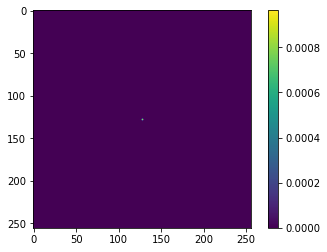

In [15]:
potential_weighted = [np.dot(p,w) for p,w in zip(potential_list,weight(samping*dx))]
plt.imshow(sum(potential_weighted))
plt.colorbar()
sum(potential_weighted).sum()

In [16]:
energy_list = np.logspace(0,3,num=10)
scs_list=differentital_edx_potential(energy_list)*(5/256)**2
plt.plot(energy_list,scs_list)
plt.show()


Transitions:   0%|          | 0/4 [00:00<?, ?it/s]/home/zzhang/code/abTEM/abtem/ionization/transitions.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([up, (l * (l + 1) / r ** 2 - 2 * vr(r) / r - e) * u])


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [ ]:
np.exp(2*E)

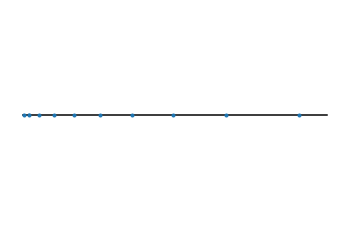

array([0.33333102])

In [42]:
import quadpy

scheme = quadpy.e1r.gauss_laguerre(10, alpha=0)
scheme.show()
val = scheme.integrate(lambda x:np.exp(-x)**2)
val

In [9]:
val

array([4.87596596e-05])

In [3]:
5/1024

0.0048828125

In [ ]:
val*(5/256)**2

array([7.71374721e-06])

In [64]:
val, error_estimate = integrate_adaptive(differentital_edx_potential, [1, 10], eps_rel=1.0E-2,kronrod_degree=10)
val, error_estimate













Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]












Transitions: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]








(0.004275910615050652, 1.9974183608232668e-05)

Transitions: 100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Text(0, 0.5, 'Differential scattering cross section $\\sigma/dE$')

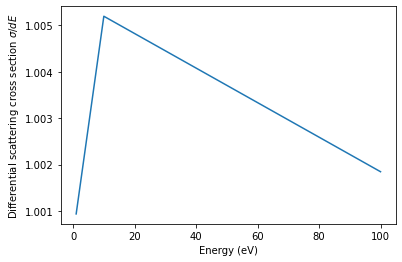

In [10]:
from abtem.measure import Measurement, calibrations_from_grid
intensity_list = []
total_list = []
intensity_list_exp = []
energy_list = [10**s for s in range(0,3)]
for e in energy_list:
    O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=e)
    atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
                                                                       gpts = 256,
                                                                       energy = 100e3)
    intensity = None
    for t in atomic_transition_potentials:
        pot = t.measure().intensity().array
        if intensity is None:
            intensity = pot
        else:
            intensity += pot
    intensity_list.append(intensity)
    total_list.append(intensity.sum())
    intensity_list_exp.append(np.exp(intensity.sum()*e))

# calibrations = (atomic_transition_potentials[0].gpts, atomic_transition_potentials[0].sampling, ['x', 'y'])
# Measurement(intensity, calibrations).show()
# atomic_transition_potentials[1].measure().intensity().show()
# np.array(t)
# plt.imshow(t)
# plt.plot(energy_list,total_list)
plt.plot(energy_list, intensity_list_exp)
plt.xlabel('Energy (eV)')
plt.ylabel(r'Differential scattering cross section $\sigma/dE$')

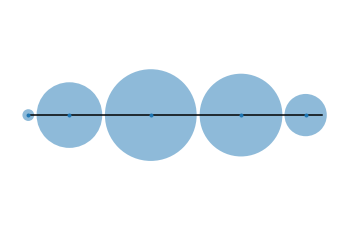

TypeError: integrate() missing 1 required positional argument: 'intervals'

In [44]:
import quadpy

scheme = quadpy.c1.gauss_radau(5)
scheme.show()
val = scheme.integrate(lambda x: x ** 2)

Text(0, 0.5, 'Differential scattering cross section $\\sigma/dE$')

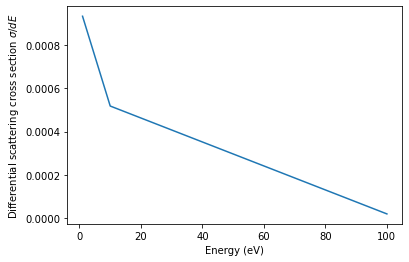

In [28]:
from mpmath import *
quad(lambda x:exp(-x),[0,inf])

mpf('1.0')

In [41]:
import tanh_sinh
import numpy

val, error_estimate = tanh_sinh.integrate(
    lambda x: np.exp(-x),
    0,
    1000,
    1.0e-14,
    # Optional: Specify first and second derivative for better error estimation
    # f_derivatives={
    #     1: lambda x: numpy.exp(x) * (numpy.cos(x) - numpy.sin(x)),
    #     2: lambda x: -2 * numpy.exp(x) * numpy.sin(x),
    # },
)
val

1.0000000000000002

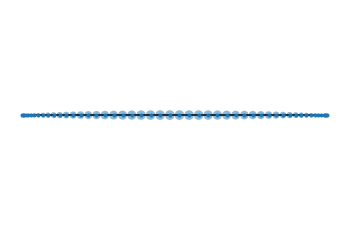

1.0006797038107542

In [34]:
import quadpy
import numpy as np

scheme = quadpy.c1.gauss_lobatto(50)
scheme.show()
val = scheme.integrate(lambda x: np.exp(-x),[0,1000])
val

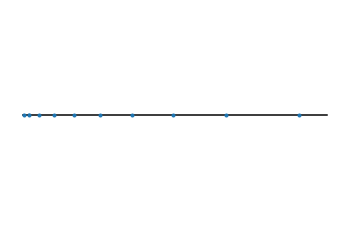

TypeError: 'list' object is not callable

In [36]:
import numpy as np
import quadpy

scheme = quadpy.e1r.gauss_laguerre(10, alpha=0)
scheme.show()
val = scheme.integrate(lambda x: np.exp(-x), [0.0, 1.0])
val

Transitions: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


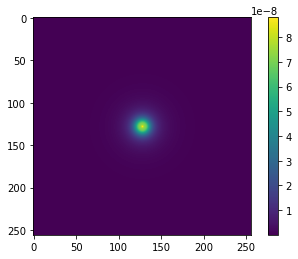

In [8]:
intensity = differentital_edx_potential(1)
plt.imshow(intensity)
plt.colorbar()

In [12]:
from scipy import integrate

f = lambda x: x**8

integrate.quadrature(f, 0.0, 1.0)

(0.11111111111111106, 4.163336342344337e-17)

Transitions: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


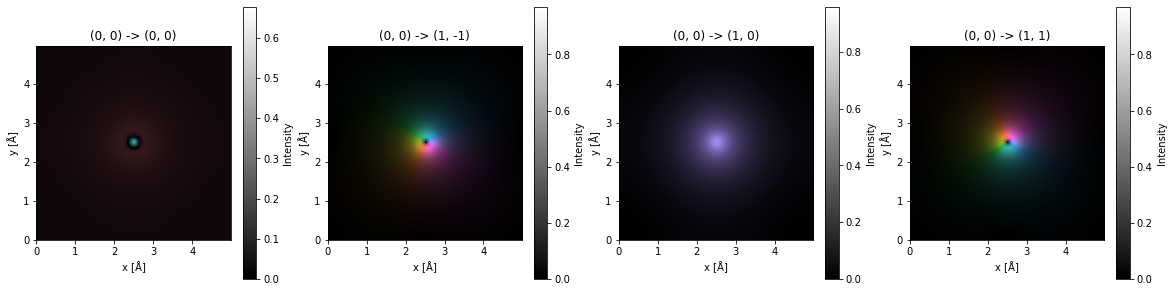

In [6]:
O_transitions = SubshellTransitions(Z = Z, n = n, l = l, xc = 'PBE',epsilon=1)
atomic_transition_potentials = O_transitions.get_transition_potentials(extent = 5,
                                                                       gpts = 256,
                                                                       energy = 100e3)

fig, axes = plt.subplots(1,4, figsize = (20,5))

for ax, atomic_transition_potential in zip(axes, atomic_transition_potentials):
    # print(str(atomic_transition_potential))
    atomic_transition_potential.show(ax = ax, title = str(atomic_transition_potential),cbar=True,cbar_label='Intensity')


In [14]:
import cplot
import numpy as np
def f(z):
    return np.sin(z ** 3) / z


plt = cplot.plot(
    f,
    (-2.0, +2.0),
    (-2.0, +2.0),
    400,
    # colorbars: bool = True,
    # abs_scaling="h-1.0",        # how to scale the lightness in domain coloring
    # colorspace: str = "cam16",  # ditto
    # abs/args contour lines:
    # contours=("auto", (-np.pi / 2, 0, np.pi / 2, np.pi)),
    # linecolors = "#a0a0a050",
    # linestyles = "solid",
    # linestyle_abs1 = "solid"
)
plt.show()

ModuleNotFoundError: No module named 'cplot'

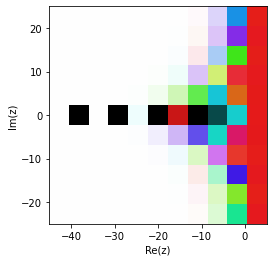

In [ ]:
import matplotlib.pyplot as plt
import mpmath
mpmath.cplot(mpmath.zeta, [-45,5],[-25,25], points=100)
# plt.colorbar()

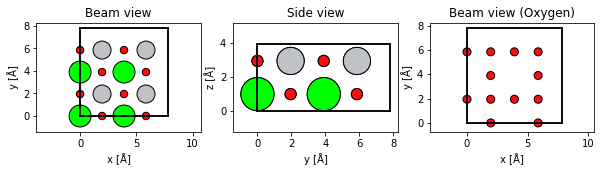

In [16]:
atoms = read('../data/srtio3_100.cif') * (2,2,1)
atoms.center(axis = 2)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,2))

show_atoms(atoms, ax = ax1, title = 'Beam view')
show_atoms(atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(atoms[atoms.numbers == 8], ax = ax3, plane = 'xy', title = 'Beam view (Oxygen)');


In [17]:
len(O_transitions)

3

In [18]:
transition_potential = TransitionPotential(O_transitions,
                                           atoms = atoms,
                                           sampling = .05,
                                           energy = 100e3,
                                           slice_thickness = 2)


In [19]:
transition_potential._calculate_potentials(0)

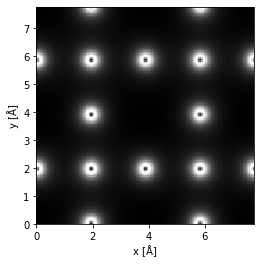

In [20]:
transition_potential.show()

In [21]:
S = SMatrix(energy = 100e3, semiangle_cutoff = 25) # interpolation not implemented!


detector = EELSDetector(collection_angle = 100, interpolation = 4)


potential = Potential(atoms, sampling = .05, slice_thickness = .5,
                      projection = 'infinite', parametrization = 'kirkland')


transition_potential = TransitionPotential(O_transitions)


scan = GridScan((0,0), potential.extent, sampling = .9*S.ctf.nyquist_sampling)


measurement = S.coreloss_scan(scan, detector, potential, transition_potential)

Forward multislice: 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


In [22]:
print(potential.extent,.9*S.ctf.nyquist_sampling)

(7.81, 7.81) 0.33312929356137355


In [23]:
s_array=scan.get_positions()
s_array

array([[0.        , 0.        ],
       [0.        , 0.32541667],
       [0.        , 0.65083333],
       ...,
       [7.48458333, 6.83375   ],
       [7.48458333, 7.15916667],
       [7.48458333, 7.48458333]])

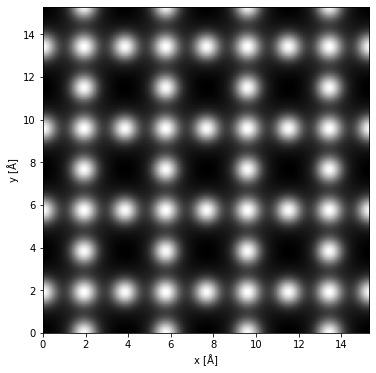

In [24]:
measurement.tile((2,2)).interpolate(.02).show(figsize = (6,6));

In [25]:
O_transitions = SubshellTransitions(Z = 8, n = 1, l = 0, xc = 'PBE')
Ti_transitions = SubshellTransitions(Z = 22, n = 2, l = 1, xc = 'PBE')
Sr_transitions = SubshellTransitions(Z = 38, n = 2, l = 1, xc = 'PBE')

transitions = [O_transitions, Ti_transitions, Sr_transitions]

transition_potential = TransitionPotential(transitions)

In [26]:
print('Oxygen:')
for bound_state, continuum_state in O_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')
print('Titanium:')
for bound_state, continuum_state in Ti_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')
print('Strontium:')
for bound_state, continuum_state in Sr_transitions.get_transition_quantum_numbers():
    print(f'(l, ml) = {bound_state} -> {continuum_state}')



Oxygen:
(l, ml) = (0, 0) -> (1, -1)
(l, ml) = (0, 0) -> (1, 0)
(l, ml) = (0, 0) -> (1, 1)
Titanium:
(l, ml) = (1, -1) -> (0, 0)
(l, ml) = (1, -1) -> (2, -2)
(l, ml) = (1, -1) -> (2, -1)
(l, ml) = (1, -1) -> (2, 0)
(l, ml) = (1, 0) -> (0, 0)
(l, ml) = (1, 0) -> (2, -1)
(l, ml) = (1, 0) -> (2, 0)
(l, ml) = (1, 0) -> (2, 1)
(l, ml) = (1, 1) -> (0, 0)
(l, ml) = (1, 1) -> (2, 0)
(l, ml) = (1, 1) -> (2, 1)
(l, ml) = (1, 1) -> (2, 2)
Strontium:
(l, ml) = (1, -1) -> (0, 0)
(l, ml) = (1, -1) -> (2, -2)
(l, ml) = (1, -1) -> (2, -1)
(l, ml) = (1, -1) -> (2, 0)
(l, ml) = (1, 0) -> (0, 0)
(l, ml) = (1, 0) -> (2, -1)
(l, ml) = (1, 0) -> (2, 0)
(l, ml) = (1, 0) -> (2, 1)
(l, ml) = (1, 1) -> (0, 0)
(l, ml) = (1, 1) -> (2, 0)
(l, ml) = (1, 1) -> (2, 1)
(l, ml) = (1, 1) -> (2, 2)


In [30]:
measurements = S.coreloss_scan(scan, detector, potential, transition_potential)

Forward multislice: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


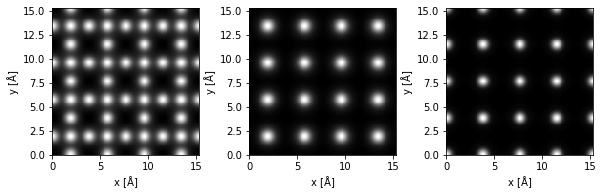

In [28]:
fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize = (10,2.7))

measurements[0].tile((2, 2)).interpolate(.1).show(ax = ax1)
measurements[1].tile((2, 2)).interpolate(.1).show(ax = ax2)
measurements[2].tile((2, 2)).interpolate(.1).show(ax = ax3);

plt.savefig('low_res_eels.jpg', bbox_inches='tight')

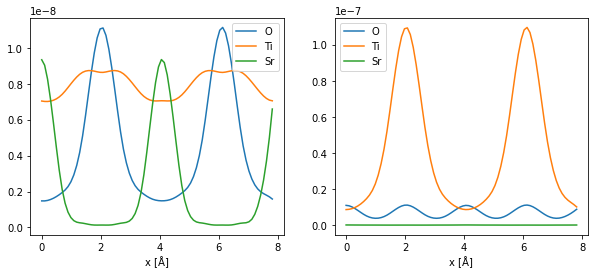

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4))

measurements[0].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'O')
measurements[1].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'Ti')
measurements[2].interpolate_line((0,0), (0, potential.extent[1]),
                                 sampling = .1).show(ax = ax1, label = 'Sr')
ax1.legend()

measurements[0].interpolate_line((atoms[3].x, 0), (atoms[3].x,potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'O')
measurements[1].interpolate_line((atoms[3].x, 0),(atoms[3].x, potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'Ti')
measurements[2].interpolate_line((atoms[3].x, 0),(atoms[3].x,potential.extent[1]),
                                 sampling = .1).show(ax = ax2, label = 'Sr')
ax2.legend();